# F20M/F21ML Coursework 2
## Part III: Deep Learning with Keras for Detecting COVID19 from XRay Images

- This notebook should be uploaded to Google Colab so that you can use GPU resources to accelerate the training for CNNs. 

In [ ]:
!pip install gdown  # gdown is used to download large files from google drive. 

## Download the Covid Xray dataset 
### Please note this dataset is based on a bigger one. Please don't distribute the dataset as it is only used for F20ML coursework. 

In [1]:
!gdown https://drive.google.com/uc?id=1GOaQpIZsFKNCkl1E3d01Bmxz_8FPoIeJ  # Covid and Normal data
#!gdown https://drive.google.com/uc?id=1Xa4IxZy5o-eUPmadnrjlJZPHe9oRw2Ol   # balanced dataset

'gdown' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


### Extract the zip file

In [3]:
import os
import zipfile

local_zip = './COVID19Subset.zip'  # you may need to change the path based on your own enviroment
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./content')
zip_ref.close()

### Loading data and perform data augmentation.


In [4]:
from keras.preprocessing.image import ImageDataGenerator

path = './content/COVID-19Subset' # you may need to change the path based on your own enviroment

classes=["COVID",  "Normal"]
num_classes = len(classes)
print(num_classes)
batch_size=16

import numpy as np
np.random.seed(25)
#split data into train and test
datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest", rescale=1./255, validation_split=0.2)

#load training image set
train_gen = datagen.flow_from_directory(directory=path, 
                                              target_size=(299, 299),
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True, classes=classes,
                                              batch_size=batch_size, 
                                              color_mode="grayscale")
#load testing set
test_gen = datagen.flow_from_directory(directory=path, 
                                              target_size=(299, 299),
                                              class_mode='categorical',
                                              subset='validation',
                                              shuffle=True, classes=classes,
                                              batch_size=batch_size, 
                                              color_mode="grayscale")



2
Found 11047 images belonging to 2 classes.
Found 2761 images belonging to 2 classes.


In [5]:
# train_gen[0][0].shape

In [6]:
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Conv3D, MaxPooling3D,GlobalAveragePooling3D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
# from keras.optimizers import Adam, SGD, RMSprop

#TODO: compelte a CNN model using Keras in the following function

In [7]:
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.initializers import glorot_uniform
import numpy as np
np.random.seed(25)

def identity_block(X, f, filters, stage, block):
 
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
 
    F1, F2, F3 = filters
 
    X_shortcut = X
 
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
 
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
 
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
 
    return X

def convolution_block(X, f, filters, stage, block, s=2):
 
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
 
    X_shortcut = X
 
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
 
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
 
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
 
    X_shortcut = Conv2D(F3, (1,1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name=bn_name_base + '1')(X_shortcut)
 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
 
    return X

def my_model(input_shape = (299, 299, 1), classes = 2):
 
    X_input = Input(input_shape)
 
    X = ZeroPadding2D((3, 3))(X_input)
 
    X = Conv2D(64, (7, 7), strides = (2,2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides = (2,2))(X)
 
    X = convolution_block(X, f = 3, filters = [64,64,256], stage = 2, block = 'a', s = 1)
    X = Dropout(0.2)(X)
    X = identity_block(X, 3, [64,64,256], stage=2, block='b')
    X = Dropout(0.2)(X)
    X = identity_block(X, 3, [64,64,256], stage=2, block='c')
    X = Dropout(0.2)(X)
    
    X = convolution_block(X, f = 3, filters = [128,128,512], stage = 3, block = 'a', s = 2)
    X = Dropout(0.2)(X)
    X = identity_block(X, 3, [128,128,512], stage=3, block='b')
    X = Dropout(0.2)(X)
    X = identity_block(X, 3, [128,128,512], stage=3, block='c')
    X = Dropout(0.2)(X)
    X = identity_block(X, 3, [128,128,512], stage=3, block='d')
 
    X = convolution_block(X, f = 3, filters = [256,256,1024], stage = 4, block = 'a', s = 2)
    X = Dropout(0.2)(X)
    X = identity_block(X, 3, [256,256,1024], stage=4, block='b')
    X = Dropout(0.2)(X)
    X = identity_block(X, 3, [256,256,1024], stage=4, block='c')
    X = Dropout(0.2)(X)
    X = identity_block(X, 3, [256,256,1024], stage=4, block='d')    
    X = Dropout(0.2)(X)
    X = identity_block(X, 3, [256,256,1024], stage=4, block='e')
    X = Dropout(0.2)(X)
    X = identity_block(X, 3, [256,256,1024], stage=4, block='f')
 
    # X = convolution_block(X, f = 3, filters = [512,512,2048], stage = 5, block = 'a', s = 2)
    # X = Dropout(0.2)(X)
    # X = identity_block(X, 3, [512,512,2048], stage=5, block='b')
    # X = Dropout(0.2)(X)
    # X = identity_block(X, 3, [512,512,2048], stage=5, block='c')
 
    X = AveragePooling2D((2, 2), name='avg_pool')(X)
 
    X = Flatten()(X)
    X = Dense(classes, activation = 'softmax', name = 'fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
 
    model = Model(inputs = X_input, outputs = X, name = 'my_model')
    model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [8]:
# check if we are using GPU
import tensorflow as tf
tf.test.gpu_device_name()  # test if GPU is availabe. GPU will be much faster. 
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9618975571369230661,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5736300544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5901902152918747417
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6"]

In [9]:
model = my_model() 
# model.summary()

In [10]:
# fit the model
epoch=41 # choose the value for this hyperparameter wisely.
class_weights = {0:3, 1:2}
history1 = model.fit(train_gen, steps_per_epoch=len(train_gen) // batch_size, validation_steps=len(test_gen) // batch_size, validation_data=test_gen, epochs=epoch, class_weight=class_weights,verbose=2)

Epoch 1/41
43/43 - 29s - loss: 46.1550 - accuracy: 0.6148 - val_loss: 0.6288 - val_accuracy: 0.6938
Epoch 2/41
43/43 - 8s - loss: 11.3669 - accuracy: 0.6134 - val_loss: 1.9354 - val_accuracy: 0.1937
Epoch 3/41
43/43 - 8s - loss: 6.8756 - accuracy: 0.6119 - val_loss: 2.1625 - val_accuracy: 0.3187
Epoch 4/41
43/43 - 8s - loss: 5.6079 - accuracy: 0.6192 - val_loss: 1.3993 - val_accuracy: 0.2562
Epoch 5/41
43/43 - 8s - loss: 3.5969 - accuracy: 0.6817 - val_loss: 1.0265 - val_accuracy: 0.1813
Epoch 6/41
43/43 - 8s - loss: 4.1445 - accuracy: 0.6366 - val_loss: 1.1100 - val_accuracy: 0.3375
Epoch 7/41
43/43 - 8s - loss: 3.5795 - accuracy: 0.6555 - val_loss: 0.9640 - val_accuracy: 0.2500
Epoch 8/41
43/43 - 8s - loss: 3.0334 - accuracy: 0.6672 - val_loss: 0.6715 - val_accuracy: 0.6187
Epoch 9/41
43/43 - 8s - loss: 3.0726 - accuracy: 0.6933 - val_loss: 0.5589 - val_accuracy: 0.7063
Epoch 10/41
43/43 - 8s - loss: 2.7440 - accuracy: 0.7340 - val_loss: 0.7215 - val_accuracy: 0.4375
Epoch 11/41
43/4

## Plot Train and validation loss curve

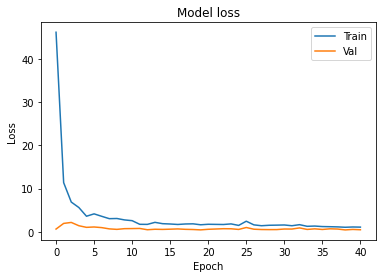

In [11]:
import matplotlib.pyplot as plt
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

## Plot Train and Validation Accuracy

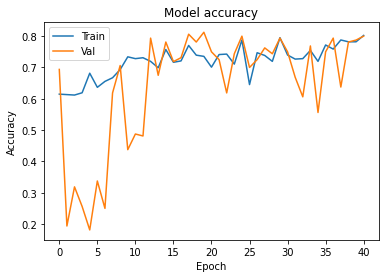

In [12]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Evaluate the model on the test set and get accuracy (>70% expected)

In [13]:
scores = model.evaluate(test_gen, steps=len(test_gen))
print(scores)
print('Model accuracy: {}'.format(scores[1]))

173/173 [==============================] - 16s 90ms/step - loss: 0.4904 - accuracy: 0.7765
[0.49038881063461304, 0.7765302658081055]
Model accuracy: 0.7765302658081055


## Test the model on the test set and report confusion matrix, and identify any issues

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# TODO: report confusion matrix on test set (test_gen)
Y_pred = np.argmax(model.predict(test_gen), axis=1)
print(classification_report(test_gen.classes, Y_pred, target_names=classes))
cm = confusion_matrix(test_gen.classes, Y_pred)

              precision    recall  f1-score   support

       COVID       0.24      0.31      0.27       723
      Normal       0.73      0.65      0.68      2038

    accuracy                           0.56      2761
   macro avg       0.48      0.48      0.48      2761
weighted avg       0.60      0.56      0.58      2761



Text(33.0, 0.5, 'Y_true')

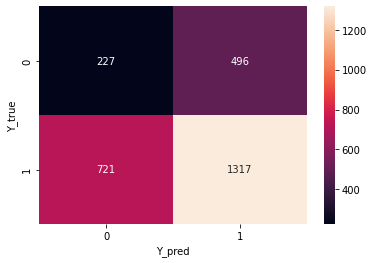

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.heatmap(cm, annot=True, fmt='.20g')
plt.xlabel('Y_pred')
plt.ylabel('Y_true')

## Perform Hyperparamter Tuning, transfer learning, or other approaches to further improve the learning performance

In [ ]:
# TODO Hyperparameter Tuning or other ways to improve learning performance here.
